## Kondaiah Moganti image analysis Nootbook 



Our highly multiplexed images are created by a cycling immunofluorescence staining approach called CyCIF (more information here: https://www.cycif.org). The file output (after preprocessing) is a multipage tiff file.

1a)	What is the size (pixels - x and y) of the image?
1b)	How many markers/channels does the image has?


2a)	Visualize Hoechst3, S100 and Vimentin as an RGB image.
2b)	Compare the intensities across all Hoechst channels (Hoechst1 to Hoechst10 - including all 10 channels). Describe any variation in signal across the 10 Hoechst channels in statistical terms.


3a)	Extract all mean intensities from each object by combining the mask and the multipage tiff. Create a table / CSV file in the format:

Object ID	Marker 1	Marker 2	Marker m
1	Mean of marker 1 in object 1	Mean of marker 2 in object 1	Mean of marker m in object 1
2	Mean of marker 1 in object 2	Mean of marker 2 in object 2	Mean of marker m in object 2
n	Mean of marker 1 in object n	Mean of marker 1 in object n	Mean of marker m in object n

3b)	Optional: How could we cluster the objects according to their marker intensity? Provide one or multiple examples.
3c)	Optional: How could we cluster the objects according to their neighborhood? Provide one or multiple examples.
3d)	Optional: Visualize the clusters from b and c directly on the image.


In [173]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
import pandas as pd
import cv2
from PIL import Image
import seaborn as sns
from skimage.measure import label, regionprops
from skimage import util, measure
from skimage import color
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc
from sklearn.preprocessing import normalize
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
%matplotlib inline
sns.set()

### Task 1
#### Extract the metadata information using your favorite software / programming language. 

In [174]:
# Read multitiff Image
image = io.imread('Example.tif')


print(image.shape)

(40, 1001, 1001)




#### 1a) What is the size (pixels - x and y) of the image? 

#### Ans: 1001 x 1001 pixels


#### 1b) How many markers/channels does the image has?

#### Ans: 40 markers


In [175]:
markers = pd.read_csv('Triplet_40_markers.csv', header = None)
markers

0
0    Hoechst1
1        A488
2        A555
3        A647
4    Hoechst2
5        pERK
6         AXL
7        MITF
8    Hoechst3
9        S100
10     VEGFR2
11        SMA
12   Hoechst4
13       KI67
14   VIMENTIN
15       PDL1
16   Hoechst5
17        CD4
18        CD3
19        CD8
20   Hoechst6
21     CD45RO
22      FOXP3
23        PD1
24   Hoechst7
25       ECAD
26     A555_7
27    CATENIN
28   Hoechst8
29       cJUN
30        pRB
31       NGFR
32   Hoechst9
33     MITF_9
34    KERATIN
35       HES1
36  Hoechst10
37        pS6
38       CD45
39      pERKz

### Task 2
####  2a) Visualize Hoechst3, S100 and Vimentin as an RGB image

In [176]:
Hoechst3 = image[8]
Hoechst3

array([[13022, 12869, 12679, ..., 16320, 15817, 16420],
       [12738, 12134, 12430, ..., 16723, 16263, 16945],
       [12446, 12214, 12181, ..., 16742, 16952, 17859],
       ...,
       [22111, 24975, 27579, ..., 61517, 63339, 63127],
       [18746, 21770, 25402, ..., 52923, 58527, 61127],
       [18411, 21885, 26622, ..., 38731, 43261, 50291]], dtype=uint16)

In [177]:
S100 = image[9]
S100

array([[32075, 34472, 37989, ..., 47069, 45138, 42511],
       [34411, 35410, 38636, ..., 45546, 44182, 41813],
       [37346, 37802, 39401, ..., 45071, 44468, 41046],
       ...,
       [37397, 33212, 30986, ..., 15390, 14087, 13554],
       [25206, 24429, 25188, ..., 16032, 14883, 13631],
       [22148, 23263, 24393, ..., 17040, 15610, 14673]], dtype=uint16)

In [178]:
Vimentin = image[14]
Vimentin

array([[ 4436,  4721,  5328, ...,  7569,  7859,  6701],
       [ 4787,  5153,  5752, ...,  7709,  8166,  7009],
       [ 5329,  5706,  6075, ...,  7734,  8093,  7353],
       ...,
       [12263, 12818, 13258, ...,  5436,  4984,  5116],
       [12504, 12856, 12923, ...,  5776,  4986,  4862],
       [12597, 12775, 12518, ...,  6269,  5755,  5331]], dtype=uint16)

In [179]:
Merged = cv2.merge([Hoechst3, S100, Vimentin])
Merged.shape

(1001, 1001, 3)

65535
1345
1.0
0.020523384451056687


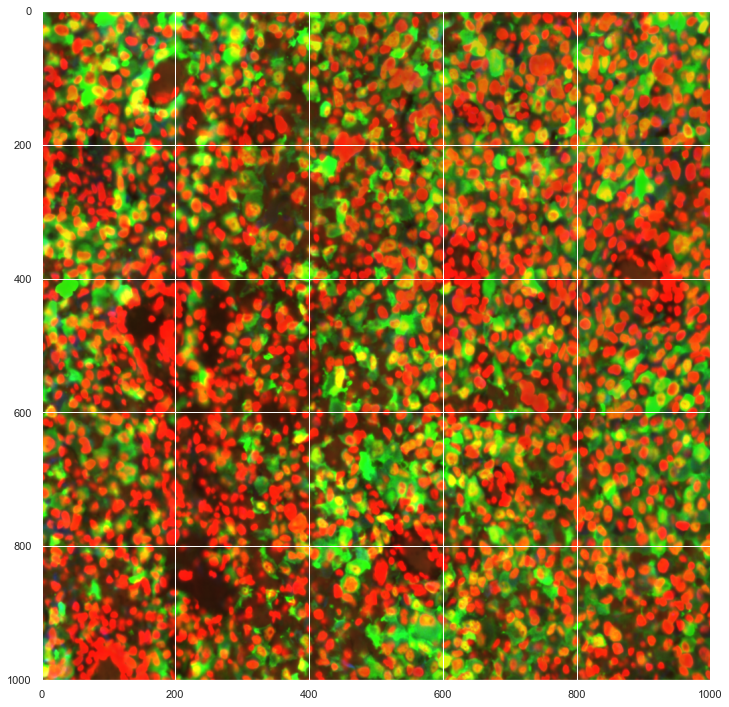

In [180]:
Merged = cv2.merge([Hoechst3, S100, Vimentin])
Merged.shape

plt.figure(figsize = (12, 18))

maxValue = np.amax(Merged)
print(maxValue)
minValue = np.amin(Merged)
print(minValue)
Image = Merged/np.amax(Merged)
maxValue = np.amax(Image)
print(maxValue)
minValue = np.amin(Image)
print(minValue)
Image = np.clip(Image, 0, 1)
plt.imshow(Image)

#### 2b) Compare the intensities across all Hoechst channels (Hoechst1 to Hoechst10 - including all 10 channels).


In [181]:
markers[0].unique()

array(['Hoechst1', 'A488', 'A555', 'A647', 'Hoechst2', 'pERK', 'AXL',
       'MITF', 'Hoechst3', 'S100', 'VEGFR2', 'SMA', 'Hoechst4', 'KI67',
       'VIMENTIN', 'PDL1', 'Hoechst5', 'CD4', 'CD3', 'CD8', 'Hoechst6',
       'CD45RO', 'FOXP3', 'PD1', 'Hoechst7', 'ECAD', 'A555_7', 'CATENIN',
       'Hoechst8', 'cJUN', 'pRB', 'NGFR', 'Hoechst9', 'MITF_9', 'KERATIN',
       'HES1', 'Hoechst10', 'pS6', 'CD45', 'pERKz'], dtype=object)

In [182]:
all_hoechst = image[[0,4,8,12,16, 20, 24, 28, 32, 36], :, :]
all_hoechst.shape

(10, 1001, 1001)

In [183]:
std=all_hoechst[0].std()
std

16488.301497500328

In [184]:
np.std(all_hoechst[0])

16488.301497500328

In [185]:
hoechst_sd = []
hoechst_var = []
hoechst_mean = []
hoechst_median = []

for i in range(all_hoechst.shape[0]):
    std = np.std(all_hoechst[i])
    var = np.var(all_hoechst[i])
    mean = np.mean(all_hoechst[i])
    median = np.median(all_hoechst[i])
    hoechst_sd.append(std)
    hoechst_var.append(var)
    hoechst_mean.append(mean)
    hoechst_median.append(median)

In [186]:
len(hoechst_sd)

10

<AxesSubplot:title={'center':'Comparision of mean intensities across all Hoechst channels'}>

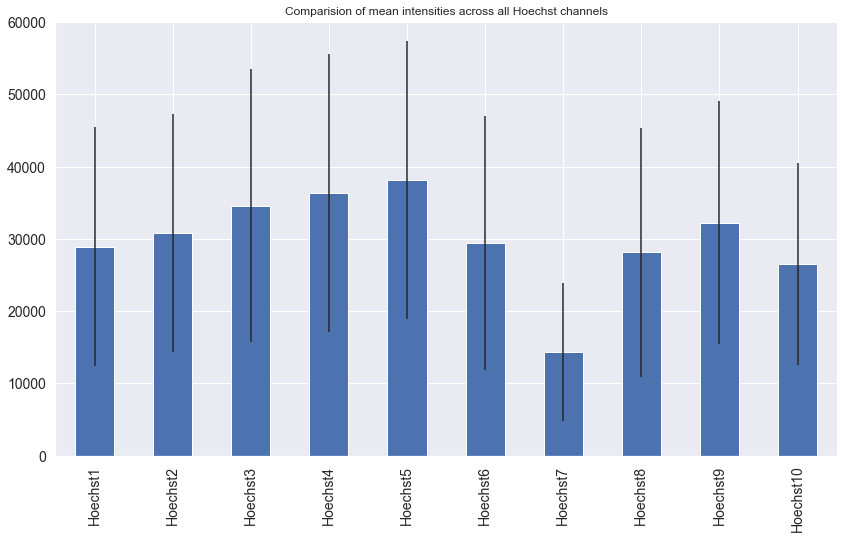

In [187]:
#plot with Mean
Hoechst_mean_SD_plot = pd.DataFrame({"Hoechst_mean": hoechst_mean, 'hoechst_sd': hoechst_sd }, 
                                    index = ['Hoechst1', 'Hoechst2', 'Hoechst3', 'Hoechst4', 'Hoechst5',
                                            'Hoechst6', 'Hoechst7', 'Hoechst8', 'Hoechst9', 'Hoechst10'])
Hoechst_mean_SD_plot.plot(kind = "bar", legend = False, 
          yerr = "hoechst_sd", title = "Comparision of mean intensities across all Hoechst channels", figsize=(14,8), fontsize=14)

<AxesSubplot:title={'center':'Comparision of median intensities across all Hoechst channels'}>

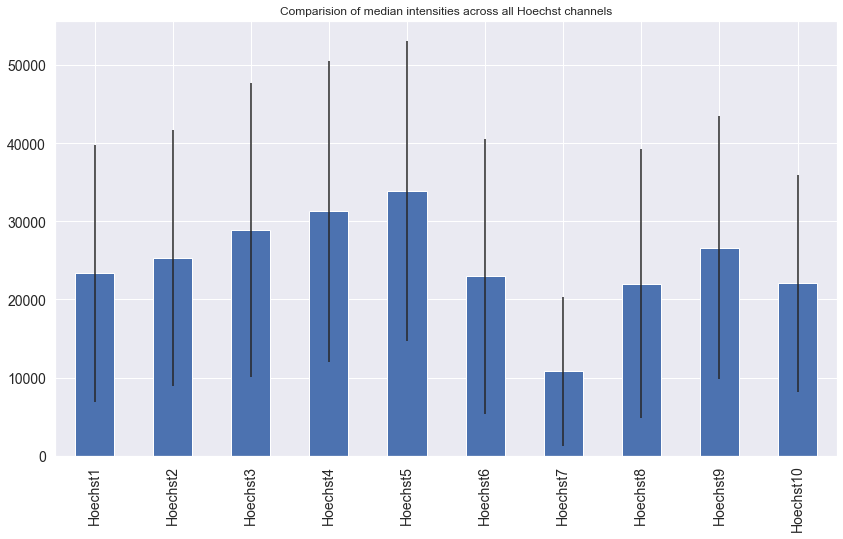

In [188]:
#Plot with Mediamn
Hoechst_median_SD_plot = pd.DataFrame({"Hoechst_median": hoechst_median, 'hoechst_sd': hoechst_sd }, 
                                    index = ['Hoechst1', 'Hoechst2', 'Hoechst3', 'Hoechst4', 'Hoechst5',
                                            'Hoechst6', 'Hoechst7', 'Hoechst8', 'Hoechst9', 'Hoechst10'])
Hoechst_median_SD_plot.plot(kind = "bar", legend = False, 
          yerr = "hoechst_sd", title = "Comparision of median intensities across all Hoechst channels", figsize=(14,8), fontsize=14)

Compared the mean and median intensities across all Hoechst channels (Hoechst1 to Hoechst10 - including all 10 channels) with standard deviation as an error bars. I have observed lowest signals in Hoechst7 compared to all other chennals. Hoechst1,Hoechst6,Hoechst8,Hoechst10 mean intensities seeems to be almost similar and highest intensity was observed in Hoechst5.

### Task 3
#### The mask represents individual objects. “1” represents an object (in this case a biological cell) and “0” represents background.


In [189]:
mask = cv2.imread('mask.tif')
#plt.imshow(mask)

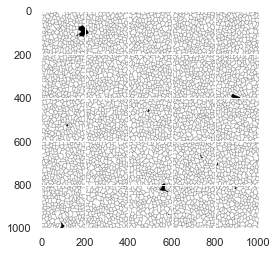

In [190]:
mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
plt.imshow(mask_gray, cmap = 'gray')
#cv2.waitKey(0)

#mask_gray

In [191]:
markers[0].unique()

array(['Hoechst1', 'A488', 'A555', 'A647', 'Hoechst2', 'pERK', 'AXL',
       'MITF', 'Hoechst3', 'S100', 'VEGFR2', 'SMA', 'Hoechst4', 'KI67',
       'VIMENTIN', 'PDL1', 'Hoechst5', 'CD4', 'CD3', 'CD8', 'Hoechst6',
       'CD45RO', 'FOXP3', 'PD1', 'Hoechst7', 'ECAD', 'A555_7', 'CATENIN',
       'Hoechst8', 'cJUN', 'pRB', 'NGFR', 'Hoechst9', 'MITF_9', 'KERATIN',
       'HES1', 'Hoechst10', 'pS6', 'CD45', 'pERKz'], dtype=object)

In [192]:
mask = cv2.imread('mask.tif', 0)
np.unique(mask)

array([  0, 255], dtype=uint8)

1.0
0.0
(1001, 1001)


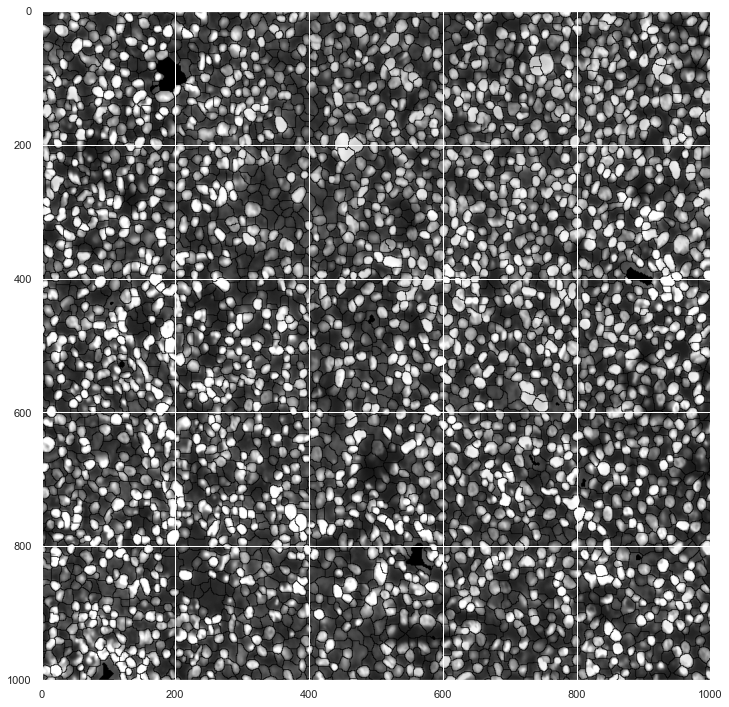

In [193]:
Hoechst1 = cv2.bitwise_and(image[0],image[0],mask = mask)
Hoechst1_1 = Hoechst1/np.amax(Hoechst1)
maxValue = np.amax(Hoechst1_1)
print(maxValue)
minValue = np.amin(Hoechst1_1)
print(minValue)
plt.figure(figsize = (12, 18))
cv2.mean(Hoechst1_1)
print(Hoechst1_1.shape)
plt.imshow(Hoechst1_1, cmap = 'gray')

####  3a) Extract all mean intensities from each object by combining the mask and the multipage tiff. 

In [194]:
labeled_mask, num_labels = ndimage.label(mask_gray, structure=[[1,1,1],[1,1,1],[1,1,1]])

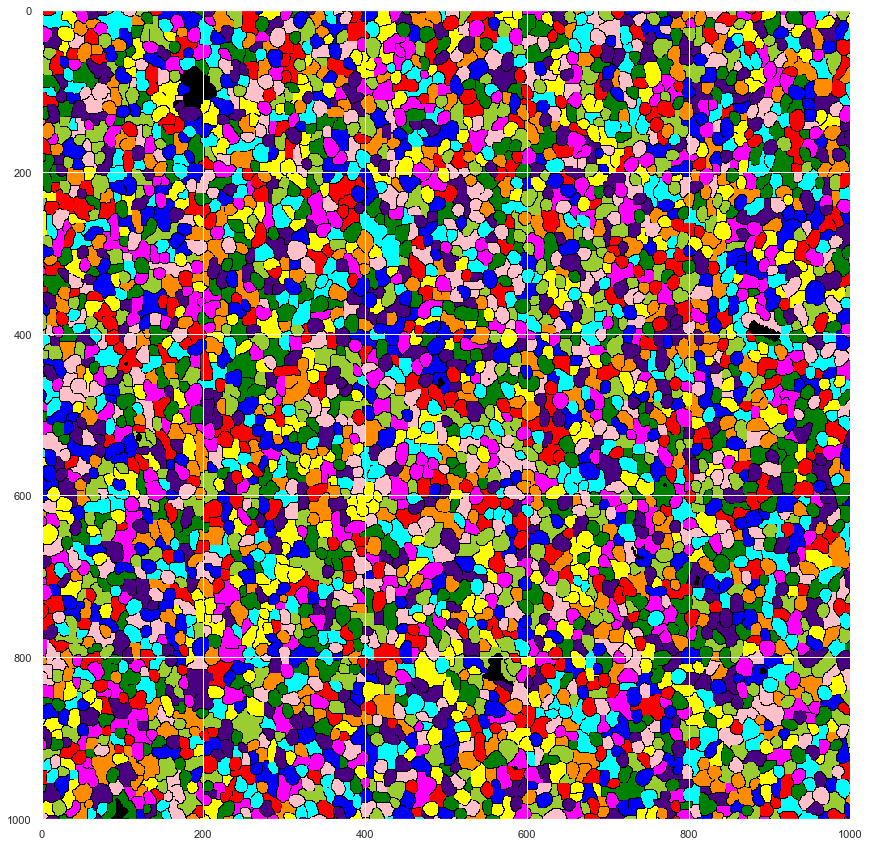

In [195]:
plt.figure(figsize=(12,12))
io.imshow(color.label2rgb(labeled_mask, bg_label=0))

In [196]:
num_labels

3933

In [197]:
Hoechst1 = measure.regionprops(labeled_mask, image[0])

In [198]:
# Extracted the mean intensities of each object in one image
Hoechst1_objects = []
for i in range(num_labels):
    object_intensity = Hoechst1[i].mean_intensity
    Hoechst1_objects.append(object_intensity)
pd.DataFrame(Hoechst1_objects).head()
#Hoechst1_objects.head()   

0
0  11899.413223
1  28492.461538
2  29919.103586
3  52468.787879
4  20109.185185

In [199]:
markers[0].unique()

array(['Hoechst1', 'A488', 'A555', 'A647', 'Hoechst2', 'pERK', 'AXL',
       'MITF', 'Hoechst3', 'S100', 'VEGFR2', 'SMA', 'Hoechst4', 'KI67',
       'VIMENTIN', 'PDL1', 'Hoechst5', 'CD4', 'CD3', 'CD8', 'Hoechst6',
       'CD45RO', 'FOXP3', 'PD1', 'Hoechst7', 'ECAD', 'A555_7', 'CATENIN',
       'Hoechst8', 'cJUN', 'pRB', 'NGFR', 'Hoechst9', 'MITF_9', 'KERATIN',
       'HES1', 'Hoechst10', 'pS6', 'CD45', 'pERKz'], dtype=object)

In [200]:
# Defined a fundtion to extract the mean intensities of each object in a image
def Object_Mean_intensity(marker):
    Object = []
    for i in range(num_labels):
        object_intensity = marker[i].mean_intensity
        Object.append(object_intensity)
    return(Object)
        

In [201]:
# Extracting the mean intensities of each object in all images

Hoechst1 = measure.regionprops(labeled_mask, image[0])
Hoechst1_int = Object_Mean_intensity(Hoechst1)

A488 = measure.regionprops(labeled_mask, image[1])
A488_int = Object_Mean_intensity(A488)

A555 = measure.regionprops(labeled_mask, image[2])
A555_int = Object_Mean_intensity(A555)

A647 = measure.regionprops(labeled_mask, image[3])
A647_int = Object_Mean_intensity(A647)

Hoechst2 =measure.regionprops(labeled_mask, image[4])
Hoechst2_int = Object_Mean_intensity(Hoechst2)

pERK = measure.regionprops(labeled_mask, image[5])
pERK_int = Object_Mean_intensity(pERK)

AXL = measure.regionprops(labeled_mask, image[6])
AXL_int = Object_Mean_intensity(AXL)

MITF= measure.regionprops(labeled_mask, image[7])
MITF_int = Object_Mean_intensity(MITF)

Hoechst3= measure.regionprops(labeled_mask, image[8])
Hoechst3_int = Object_Mean_intensity(Hoechst3)

S100 = measure.regionprops(labeled_mask, image[9])
S100_int = Object_Mean_intensity(S100)

VEGFR2 = measure.regionprops(labeled_mask, image[10])
VEGFR2_int = Object_Mean_intensity(VEGFR2)

In [202]:
SMA= measure.regionprops(labeled_mask, image[11])
SMA_int= Object_Mean_intensity(SMA)

Hoechst4 = measure.regionprops(labeled_mask, image[12])
Hoechst4_int= Object_Mean_intensity(Hoechst4)

KI67 = measure.regionprops(labeled_mask, image[13])
KI67_int= Object_Mean_intensity(KI67)

VIMENTIN = measure.regionprops(labeled_mask, image[14]) 
VIMENTIN_int= Object_Mean_intensity(VIMENTIN)

PDL1 = measure.regionprops(labeled_mask, image[15]) 
PDL1_int= Object_Mean_intensity(PDL1)

Hoechst5= measure.regionprops(labeled_mask, image[16]) 
Hoechst5_int= Object_Mean_intensity(Hoechst5)

CD4= measure.regionprops(labeled_mask, image[17])
CD4_int= Object_Mean_intensity(CD4)

CD3= measure.regionprops(labeled_mask, image[18]) 
CD3_int= Object_Mean_intensity(CD3)

CD8= measure.regionprops(labeled_mask, image[19]) 
CD8_int= Object_Mean_intensity(CD8)

Hoechst6 = measure.regionprops(labeled_mask, image[20])
Hoechst6_int= Object_Mean_intensity(Hoechst6)

CD45RO = measure.regionprops(labeled_mask, image[21])
CD45RO_int= Object_Mean_intensity(CD45RO)

In [203]:
FOXP3= measure.regionprops(labeled_mask, image[22])
FOXP3_int= Object_Mean_intensity(FOXP3)

PD1= measure.regionprops(labeled_mask, image[23])
PD1_int= Object_Mean_intensity(PD1)

Hoechst7 = measure.regionprops(labeled_mask, image[24])
Hoechst7_int= Object_Mean_intensity(Hoechst7)

ECAD = measure.regionprops(labeled_mask, image[25])
ECAD_int= Object_Mean_intensity(ECAD)

A555_7 = measure.regionprops(labeled_mask, image[26])
A555_7_int= Object_Mean_intensity(A555_7)

CATENIN = measure.regionprops(labeled_mask, image[27])
CATENIN_int= Object_Mean_intensity(CATENIN)

Hoechst8 = measure.regionprops(labeled_mask, image[28])
Hoechst8_int= Object_Mean_intensity(Hoechst8)

cJUN = measure.regionprops(labeled_mask, image[29])
cJUN_int= Object_Mean_intensity(cJUN)

pRB = measure.regionprops(labeled_mask, image[30])
pRB_int= Object_Mean_intensity(pRB)

NGFR = measure.regionprops(labeled_mask, image[31])
NGFR_int= Object_Mean_intensity(NGFR)

Hoechst9 = measure.regionprops(labeled_mask, image[32])
Hoechst9_int= Object_Mean_intensity(Hoechst9)

MITF_9 = measure.regionprops(labeled_mask, image[33])
MITF_9_int= Object_Mean_intensity(MITF_9)

KERATIN = measure.regionprops(labeled_mask, image[34])
KERATIN_int= Object_Mean_intensity(KERATIN)

HES1 = measure.regionprops(labeled_mask, image[35])
HES1_int= Object_Mean_intensity(HES1)

Hoechst10 = measure.regionprops(labeled_mask, image[36])
Hoechst10_int= Object_Mean_intensity(Hoechst10)

pS6 = measure.regionprops(labeled_mask, image[37])
pS6_int= Object_Mean_intensity(pS6)

CD45 = measure.regionprops(labeled_mask, image[38])
CD45_int= Object_Mean_intensity(CD45)

pERKz = measure.regionprops(labeled_mask, image[39])
pERKz_int= Object_Mean_intensity(pERKz)

In [204]:
# Merged all the mean intensities columns 
col = np.column_stack([Hoechst1_int, A488_int, A555_int, A647_int, Hoechst2_int, pERK_int, AXL_int,
       MITF_int, Hoechst3_int, S100_int, VEGFR2_int, SMA_int, Hoechst4_int, KI67_int,
       VIMENTIN_int, PDL1_int, Hoechst5_int, CD4_int, CD3_int, CD8_int, Hoechst6_int,
       CD45RO_int, FOXP3_int, PD1_int, Hoechst7_int, ECAD_int, A555_7_int, CATENIN_int,
       Hoechst8_int, cJUN_int, pRB_int, NGFR_int, Hoechst9_int, MITF_9_int, KERATIN_int,
       HES1_int, Hoechst10_int, pS6_int, CD45_int, pERKz_int])
col

array([[11899.41322314, 10876.69421488,  4602.46280992, ...,
        14493.4214876 ,  1430.94214876,  1820.8677686 ],
       [28492.46153846, 11025.15384615,  4819.53846154, ...,
        18651.15384615,  1453.07692308,  1736.69230769],
       [29919.10358566, 15732.28286853,  6540.19521912, ...,
        12560.11155378,  1779.98406375,  2033.43824701],
       ...,
       [17256.        ,  8820.2       ,  3498.        , ...,
         9919.        ,  1016.6       ,  2649.6       ],
       [29586.        , 11729.16666667,  4974.66666667, ...,
         7339.33333333,  1001.66666667,  1635.16666667],
       [18199.        , 11371.        ,  4373.5       , ...,
        11495.        ,  1571.        ,  2981.        ]])

In [205]:
# Generated a data frame using python
Mean_int_object = pd.DataFrame(col, columns=['Hoechst1', 'A488', 'A555', 'A647', 'Hoechst2', 'pERK', 'AXL',
       'MITF', 'Hoechst3', 'S100', 'VEGFR2', 'SMA', 'Hoechst4', 'KI67',
       'VIMENTIN', 'PDL1', 'Hoechst5', 'CD4', 'CD3', 'CD8', 'Hoechst6',
       'CD45RO', 'FOXP3', 'PD1', 'Hoechst7', 'ECAD', 'A555_7', 'CATENIN',
       'Hoechst8', 'cJUN', 'pRB', 'NGFR', 'Hoechst9', 'MITF_9', 'KERATIN',
       'HES1', 'Hoechst10', 'pS6', 'CD45', 'pERKz'])

In [206]:
Mean_int_object

Hoechst1          A488         A555         A647      Hoechst2  \
0     11899.413223  10876.694215  4602.462810  2325.314050  15182.644628   
1     28492.461538  11025.153846  4819.538462  2464.153846  31177.538462   
2     29919.103586  15732.282869  6540.195219  2885.505976  31359.884462   
3     52468.787879  15144.202020  6446.318182  2757.343434  46344.934343   
4     20109.185185  19177.111111  8310.851852  3018.296296  24012.296296   
...            ...           ...          ...          ...           ...   
3928  14493.555556  10827.222222  4264.333333  2712.555556  19681.555556   
3929  24959.700000  13326.400000  6790.200000  3736.000000  29235.200000   
3930  17256.000000   8820.200000  3498.000000  3613.000000  20613.000000   
3931  29586.000000  11729.166667  4974.666667  2509.333333  26689.833333   
3932  18199.000000  11371.000000  4373.500000  3424.000000  16618.500000   

              pERK           AXL          MITF      Hoechst3          S100  \
0     11132.661157   7148.760331   5513.644628  13579.876033  28634.008264   
1     11856.769231   7381.076923  12124.923077  35679.230769  17925.846154   
2     13967.462151  10679.569721   5245.003984  34253.000000  19577.860558   
3     21624.191919  10228.479798   5293.520202  57016.070707  17551.181818   
4     30572.074074  13772.740741   6414.037037  22180.740741  22441.592593   
...            ...           ...           ...           ...           ...   
3928  12256.777778   7546.222222   9924.444444  15836.666667  33590.444444   
3929  14260.200000   8557.400000  12818.500000  30771.400000  17458.800000   
3930   9261.400000   7396.600000   9008.000000  19951.800000  29080.000000   
3931  12726.333333   8362.166667  10928.500000  36927.333333  19979.833333   
3932  10969.000000   9866.500000   4919.000000  21030.500000  13220.500000   

      ...          pRB         NGFR      Hoechst9       MITF_9      KERATIN  \
0     ...  1507.834711  5724.595041  14938.801653  6668.107438  1853.471074   
1     ...  1645.384615  8088.692308  28491.692308  7893.384615  1872.769231   
2     ...  1614.366534  2117.772908  32624.533865  7490.278884  2082.888446   
3     ...  1669.297980  1491.388889  45149.005051  7449.358586  2107.570707   
4     ...  1768.037037  1462.222222  31050.148148  8122.814815  2167.740741   
...   ...          ...          ...           ...          ...          ...   
3928  ...  1071.666667  1338.555556  14174.222222  5568.333333  1351.888889   
3929  ...  1408.300000  1377.900000  24976.900000  7861.900000  1494.800000   
3930  ...  1306.400000  1318.200000  15850.200000  6546.000000  1336.800000   
3931  ...  1676.166667  1329.333333  28724.833333  7914.666667  1688.833333   
3932  ...  1304.000000  1422.500000  18305.500000  6026.000000  1619.500000   

              HES1     Hoechst10           pS6         CD45        pERKz  
0     21140.537190  13948.793388  14493.421488  1430.942149  1820.867769  
1     13188.230769  24786.230769  18651.153846  1453.076923  1736.692308  
2     10470.741036  27360.876494  12560.111554  1779.984064  2033.438247  
3     14377.454545  37402.883838  11736.166667  2154.535354  2059.171717  
4     18365.518519  24274.444444  10207.037037  1891.000000  2094.925926  
...            ...           ...           ...          ...          ...  
3928   9350.000000  12182.333333  13188.555556   931.777778  2344.444444  
3929  14786.300000  18424.800000  12682.200000  1154.300000  2040.000000  
3930  14517.400000  13359.600000   9919.000000  1016.600000  2649.600000  
3931  13704.333333  21562.166667   7339.333333  1001.666667  1635.166667  
3932  49618.500000  15047.500000  11495.000000  1571.000000  2981.000000  

[3933 rows x 40 columns]

<AxesSubplot:>

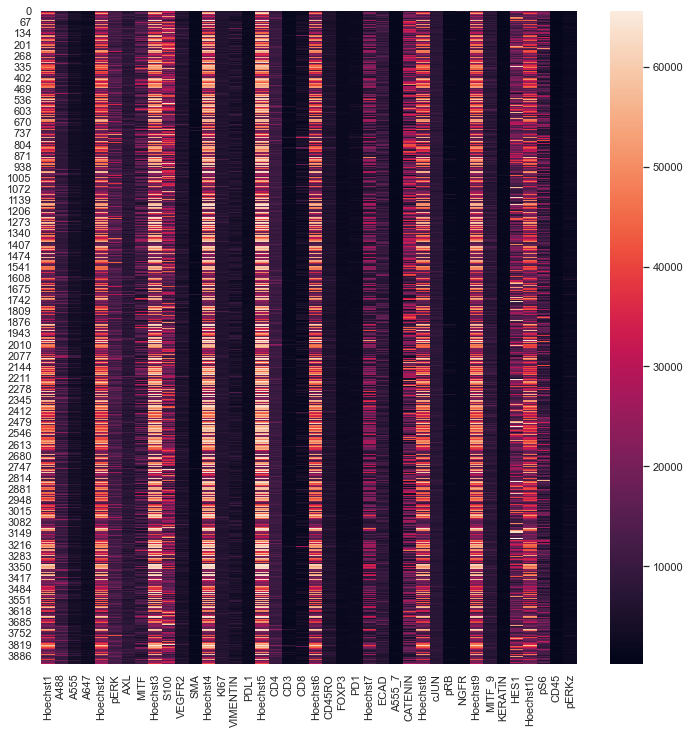

In [207]:
#Visulization of the above table
plt.figure(figsize=(12,12))
sns.heatmap(Mean_int_object)

### Create a table / CSV file in the format

In [208]:
#exported to CSV file
#Mean_int_object.to_csv('Object_mean_intensities', index = False, header=True)

In [209]:
#pd.read_csv('Object_mean_intensities')

### task 3 (optional)
####  3a) How could we cluster the objects according to their marker intensity?
#### By using Hierarchical Clustering method we can cluster based on the Composition (Markers intensity)

#### 3b) How could we cluster the objects according to their neighborhood?
#### By using K Means clustering we can cluster the cells according to the X,Y centroid

### 3c) Visualize the clusters from b and c directly on the image

### Hierarchical Clustering 

In [210]:
# Visualize the clusters from b and c directly on the image
x = np.log(Mean_int_object)

In [211]:
x

Hoechst1      A488      A555      A647   Hoechst2       pERK       AXL  \
0      9.384244  9.294378  8.434347  7.751610   9.627908   9.317639  8.874694   
1     10.257395  9.307935  8.480433  7.809604  10.347453   9.380654  8.906675   
2     10.306252  9.663470  8.785722  7.967456  10.353285   9.544486  9.276088   
3     10.867974  9.625373  8.771264  7.922023  10.743867   9.981568  9.232931   
4      9.908932  9.861473  9.025317  8.012448  10.086321  10.327842  9.530447   
...         ...       ...       ...       ...        ...        ...       ...   
3928   9.581459  9.289819  8.358041  7.905646   9.887437   9.413834  8.928802   
3929  10.125018  9.497502  8.823236  8.225771  10.283129   9.565228  9.054552   
3930   9.755915  9.084800  8.159947  8.192294   9.933677   9.133611  8.908776   
3931  10.295057  9.369834  8.512114  7.827772  10.192038   9.451429  9.031473   
3932   9.809122  9.338822  8.383319  8.138565   9.718272   9.302828  9.196900   

          MITF   Hoechst3       S100  ...       pRB      NGFR   Hoechst9  \
0     8.614981   9.516344  10.262350  ...  7.318430  8.652527   9.611717   
1     9.403018  10.482324   9.793999  ...  7.405729  8.998222  10.257368   
2     8.565031  10.441529   9.882155  ...  7.386698  7.658120  10.392820   
3     8.574239  10.951088   9.772877  ...  7.420158  7.307463  10.717724   
4     8.766244  10.006980  10.018671  ...  7.477625  7.287713  10.343359   
...        ...        ...        ...  ...       ...       ...        ...   
3928  9.202756   9.670083  10.421997  ...  6.976970  7.199346   9.559180   
3929  9.458645  10.334341   9.767599  ...  7.250139  7.228316  10.125707   
3930  9.105868   9.901075  10.277806  ...  7.175031  7.184022   9.670937   
3931  9.299129  10.516707   9.902479  ...  7.424265  7.192433  10.265517   
3932  8.500861   9.953729   9.489524  ...  7.173192  7.260171   9.814957   

        MITF_9   KERATIN       HES1  Hoechst10       pS6      CD45     pERKz  
0     8.805091  7.524815   9.958948   9.543148  9.581450  7.266088  7.507068  
1     8.973780  7.535173   9.487080  10.118044  9.833663  7.281439  7.459738  
2     8.921361  7.641511   9.256340  10.216869  9.438281  7.484360  7.617483  
3     8.915883  7.653291   9.573417  10.529503  9.370431  7.675330  7.630059  
4     9.002432  7.681441   9.818230  10.097179  9.230833  7.544861  7.647273  
...        ...       ...        ...        ...       ...       ...       ...  
3928  8.624851  7.209258   9.143132   9.407742  9.487105  6.837094  7.759804  
3929  8.969784  7.309748   9.601456   9.821453  9.447955  7.051249  7.620705  
3930  8.786609  7.198034   9.583103   9.499991  9.202207  6.924219  7.882164  
3931  8.976473  7.431793   9.525467   9.978696  8.901003  6.909421  7.399500  
3932  8.703839  7.389873  10.812119   9.618967  9.349667  7.359468  8.000014  

[3933 rows x 40 columns]

In [260]:
all_hoechst_log = x[['Hoechst1', 'Hoechst2', 'Hoechst3', 'Hoechst4', 'Hoechst5', 'Hoechst6', 'Hoechst7', 'Hoechst8', 'Hoechst9', 'Hoechst10']]
all_hoechst_log

Hoechst1   Hoechst2   Hoechst3   Hoechst4   Hoechst5   Hoechst6  \
0      9.384244   9.627908   9.516344   9.533997   9.760768   9.316626   
1     10.257395  10.347453  10.482324  10.599446  10.739637  10.164134   
2     10.306252  10.353285  10.441529  10.434852  10.526769  10.239467   
3     10.867974  10.743867  10.951088  10.959233  10.998249  10.765722   
4      9.908932  10.086321  10.006980   9.827934  10.005962   9.867549   
...         ...        ...        ...        ...        ...        ...   
3928   9.581459   9.887437   9.670083   9.772778   9.769010   9.404243   
3929  10.125018  10.283129  10.334341  10.345754  10.434051  10.037721   
3930   9.755915   9.933677   9.901075   9.990023   9.993237   9.561814   
3931  10.295057  10.192038  10.516707  10.620974  10.602323  10.239162   
3932   9.809122   9.718272   9.953729   9.979870  10.040986   9.649788   

       Hoechst7   Hoechst8   Hoechst9  Hoechst10  
0      8.780784   9.218175   9.611717   9.543148  
1      9.541568  10.020682  10.257368  10.118044  
2      9.550833  10.174221  10.392820  10.216869  
3     10.093240  10.606759  10.717724  10.529503  
4      9.058682   9.999257  10.343359  10.097179  
...         ...        ...        ...        ...  
3928   8.678253   9.244216   9.559180   9.407742  
3929   9.269147  10.039233  10.125707   9.821453  
3930   8.889170   9.435929   9.670937   9.499991  
3931   9.429128  10.117247  10.265517   9.978696  
3932   8.956158   9.678843   9.814957   9.618967  

[3933 rows x 10 columns]

In [264]:
all_hoechst_log['Hoechst1'].mean()

10.224005062947358

In [276]:
np.mean(all_hoechst_log['Hoechst1'])

10.224005062947358

In [265]:
all_hoechst_log.shape

(3933, 10)

In [271]:
all_hoechst_log.columns

Index(['Hoechst1', 'Hoechst2', 'Hoechst3', 'Hoechst4', 'Hoechst5', 'Hoechst6',
       'Hoechst7', 'Hoechst8', 'Hoechst9', 'Hoechst10'],
      dtype='object')

In [280]:
all_hoechst_log_mean = []
all_hoechst_log_sd = []
all_hoechst_log_var = []
all_hoechst_log_median = []

for i in all_hoechst_log.columns:
    mean = np.mean(all_hoechst_log[i])
    median = np.median(all_hoechst_log[i])
    sd = np.std(all_hoechst_log[i])
    var = np.var(all_hoechst_log[i])
    all_hoechst_log_mean.append(mean)
    all_hoechst_log_median.append(median)
    all_hoechst_log_sd.append(sd)
    all_hoechst_log_var.append(var)
    

<AxesSubplot:title={'center':'Comparision of mean intensities across all Hoechst channels'}>

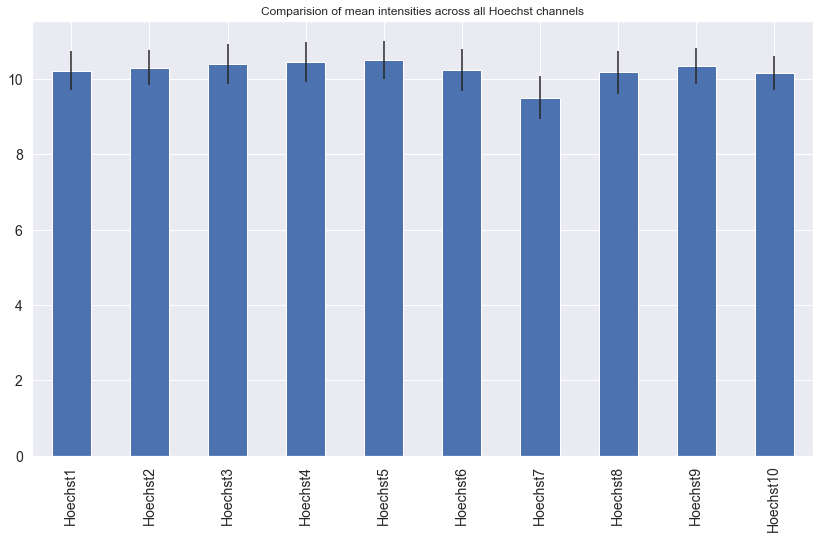

In [281]:
#plot with Mean
Hoechst_mean_log_SD_plot = pd.DataFrame({"Hoechst_mean": all_hoechst_log_mean, 'hoechst_sd': all_hoechst_log_sd }, 
                                    index = ['Hoechst1', 'Hoechst2', 'Hoechst3', 'Hoechst4', 'Hoechst5',
                                            'Hoechst6', 'Hoechst7', 'Hoechst8', 'Hoechst9', 'Hoechst10'])
Hoechst_mean_log_SD_plot.plot(kind = "bar", legend = False, 
          yerr = "hoechst_sd", title = "Comparision of mean intensities across all Hoechst channels", figsize=(14,8), fontsize=14)

<AxesSubplot:title={'center':'Comparision of mean intensities across all Hoechst channels'}>

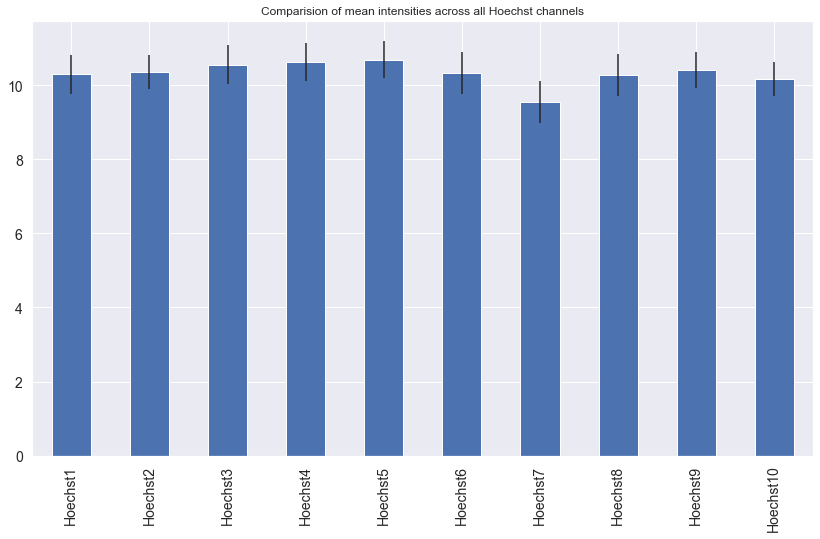

In [283]:
Hoechst_median_log_SD_plot = pd.DataFrame({"Hoechst_median": all_hoechst_log_median, 'hoechst_sd': all_hoechst_log_sd }, 
                                    index = ['Hoechst1', 'Hoechst2', 'Hoechst3', 'Hoechst4', 'Hoechst5',
                                            'Hoechst6', 'Hoechst7', 'Hoechst8', 'Hoechst9', 'Hoechst10'])
Hoechst_median_log_SD_plot.plot(kind = "bar", legend = False, 
          yerr = "hoechst_sd", title = "Comparision of mean intensities across all Hoechst channels", figsize=(14,8), fontsize=14)

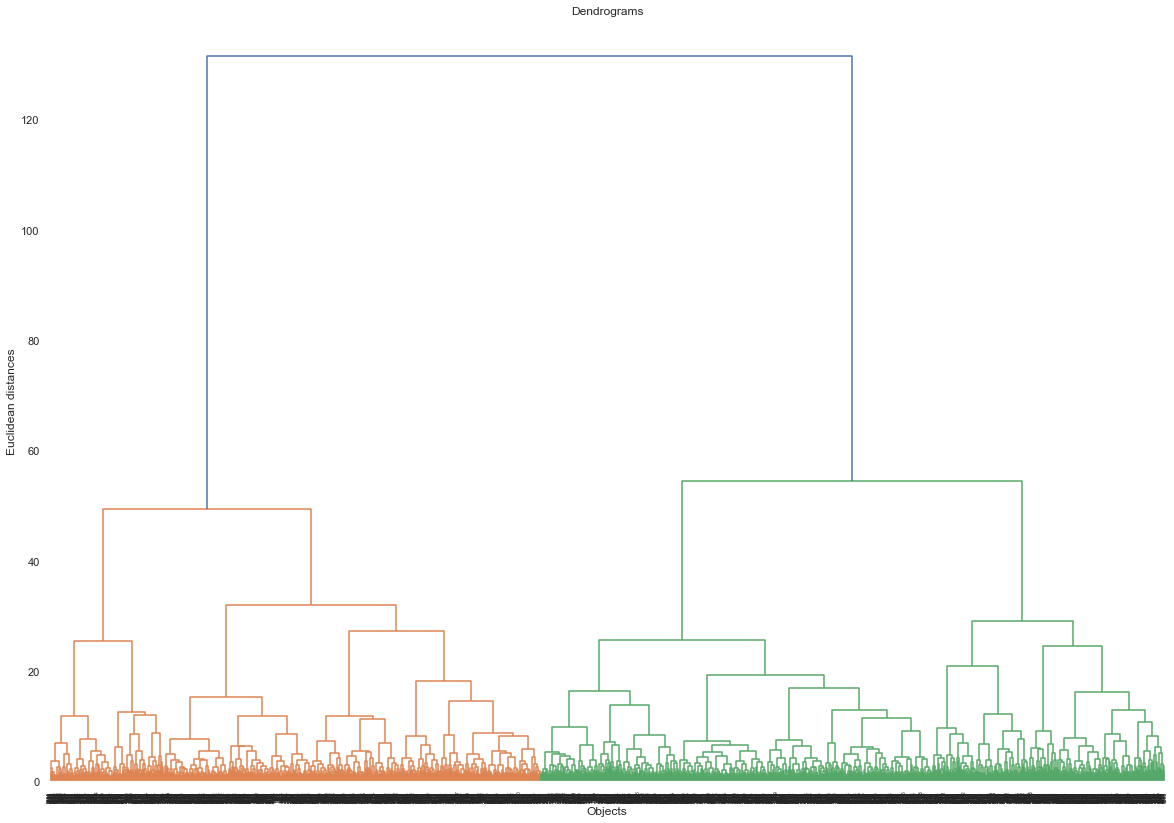

In [212]:
plt.figure(figsize=(20, 14))  

plt.title("Dendrograms")  

dend = shc.dendrogram(shc.linkage(x, method='ward'))
plt.xlabel('Objects')
plt.ylabel('Euclidean distances')
plt.show()

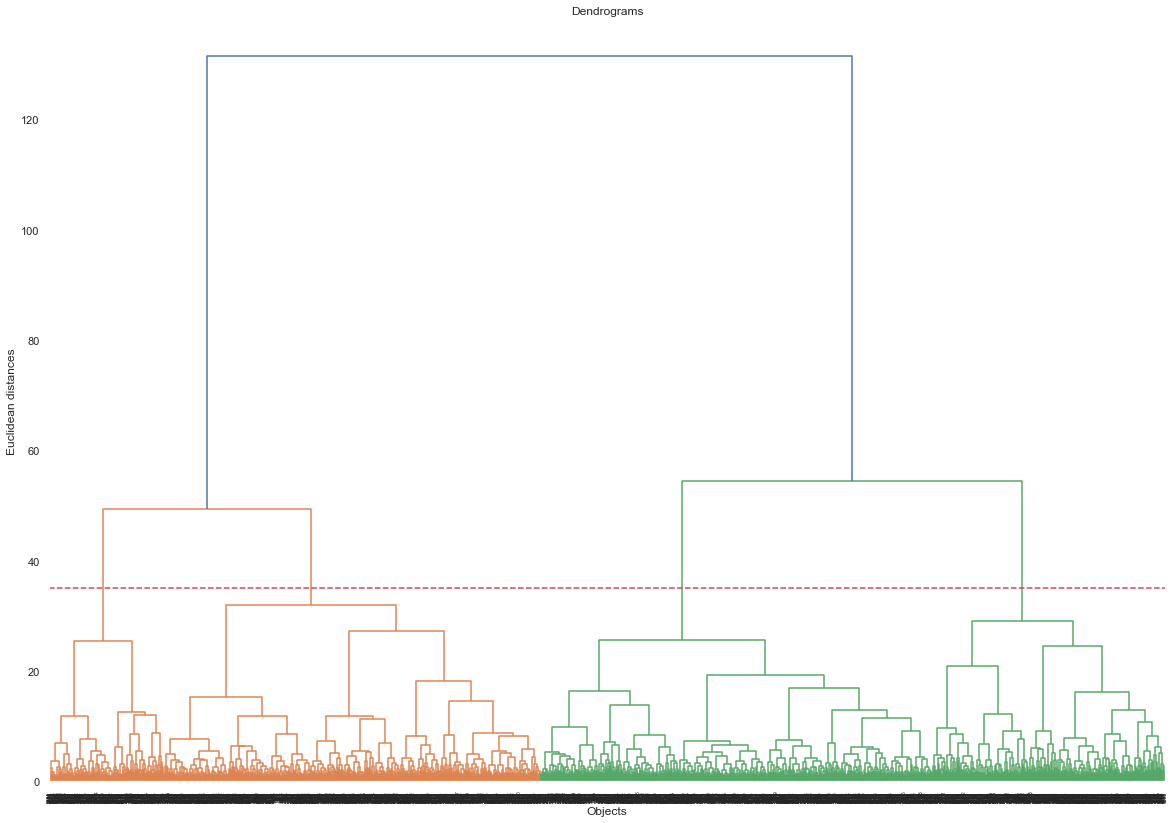

In [213]:
plt.figure(figsize=(20, 14))  

plt.title("Dendrograms")

z = shc.linkage(x, method='ward')

dend = shc.dendrogram( z )

plt.axhline(y=35, color='r', linestyle='--')
plt.xlabel('Objects')
plt.ylabel('Euclidean distances')
plt.show()
plt.show()

In [214]:
#from sklearn.cluster import AgglomerativeClustering

#cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')

In [215]:
#clu_pred = cluster.fit_predict(data_scaled)
#np.unique(clu_pred)

In [216]:
#cluster.labels_

In [217]:
#sns.clustermap(data_scaled, metric="euclidean", standard_scale=1, method="ward", figsize=(15,15))

### K Means Clustering

In [218]:
kmeans = KMeans(4)

In [219]:
kmeans.fit(x)

KMeans(n_clusters=4)

In [220]:
identified_clusters = kmeans.fit_predict(x)
identified_clusters

array([3, 0, 3, ..., 1, 2, 3])

In [221]:
data_with_clusters = x.copy()
data_with_clusters['Cluster'] = identified_clusters
data_with_clusters

Hoechst1      A488      A555      A647   Hoechst2       pERK       AXL  \
0      9.384244  9.294378  8.434347  7.751610   9.627908   9.317639  8.874694   
1     10.257395  9.307935  8.480433  7.809604  10.347453   9.380654  8.906675   
2     10.306252  9.663470  8.785722  7.967456  10.353285   9.544486  9.276088   
3     10.867974  9.625373  8.771264  7.922023  10.743867   9.981568  9.232931   
4      9.908932  9.861473  9.025317  8.012448  10.086321  10.327842  9.530447   
...         ...       ...       ...       ...        ...        ...       ...   
3928   9.581459  9.289819  8.358041  7.905646   9.887437   9.413834  8.928802   
3929  10.125018  9.497502  8.823236  8.225771  10.283129   9.565228  9.054552   
3930   9.755915  9.084800  8.159947  8.192294   9.933677   9.133611  8.908776   
3931  10.295057  9.369834  8.512114  7.827772  10.192038   9.451429  9.031473   
3932   9.809122  9.338822  8.383319  8.138565   9.718272   9.302828  9.196900   

          MITF   Hoechst3       S100  ...      NGFR   Hoechst9    MITF_9  \
0     8.614981   9.516344  10.262350  ...  8.652527   9.611717  8.805091   
1     9.403018  10.482324   9.793999  ...  8.998222  10.257368  8.973780   
2     8.565031  10.441529   9.882155  ...  7.658120  10.392820  8.921361   
3     8.574239  10.951088   9.772877  ...  7.307463  10.717724  8.915883   
4     8.766244  10.006980  10.018671  ...  7.287713  10.343359  9.002432   
...        ...        ...        ...  ...       ...        ...       ...   
3928  9.202756   9.670083  10.421997  ...  7.199346   9.559180  8.624851   
3929  9.458645  10.334341   9.767599  ...  7.228316  10.125707  8.969784   
3930  9.105868   9.901075  10.277806  ...  7.184022   9.670937  8.786609   
3931  9.299129  10.516707   9.902479  ...  7.192433  10.265517  8.976473   
3932  8.500861   9.953729   9.489524  ...  7.260171   9.814957  8.703839   

       KERATIN       HES1  Hoechst10       pS6      CD45     pERKz  Cluster  
0     7.524815   9.958948   9.543148  9.581450  7.266088  7.507068        3  
1     7.535173   9.487080  10.118044  9.833663  7.281439  7.459738        0  
2     7.641511   9.256340  10.216869  9.438281  7.484360  7.617483        3  
3     7.653291   9.573417  10.529503  9.370431  7.675330  7.630059        0  
4     7.681441   9.818230  10.097179  9.230833  7.544861  7.647273        3  
...        ...        ...        ...       ...       ...       ...      ...  
3928  7.209258   9.143132   9.407742  9.487105  6.837094  7.759804        1  
3929  7.309748   9.601456   9.821453  9.447955  7.051249  7.620705        3  
3930  7.198034   9.583103   9.499991  9.202207  6.924219  7.882164        1  
3931  7.431793   9.525467   9.978696  8.901003  6.909421  7.399500        2  
3932  7.389873  10.812119   9.618967  9.349667  7.359468  8.000014        3  

[3933 rows x 41 columns]

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\matrix.py:654: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



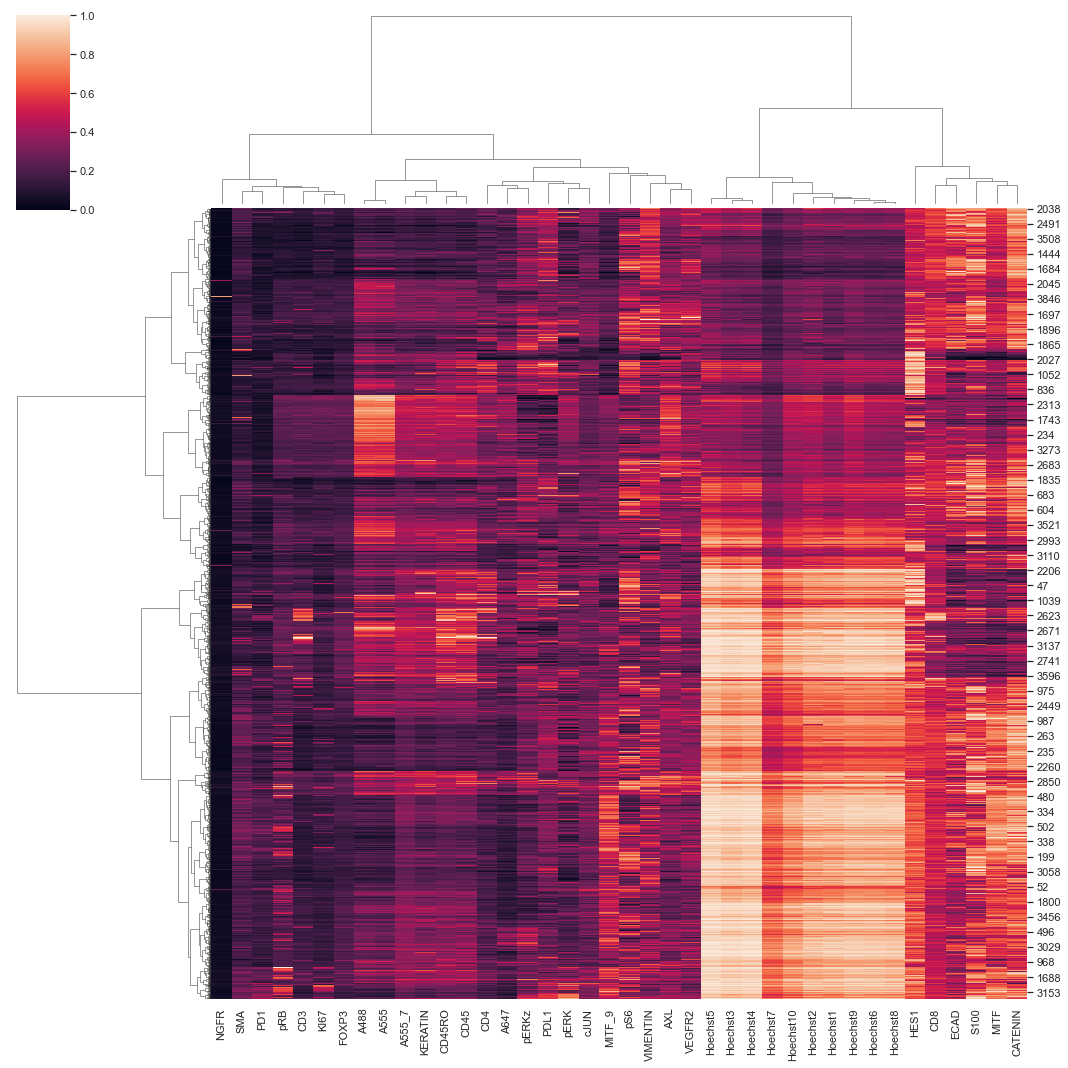

In [222]:
sns.clustermap(data_with_clusters.drop(['Cluster'], axis =1), metric="euclidean", standard_scale=1, method="ward", figsize=(15,15))

In [223]:

#PCA with two principal components
pca_2d = PCA(n_components=2)

#PCA with three principal components
pca_3d = PCA(n_components=3)



In [224]:
#This DataFrame contains the two principal components that will be used
#for the 2-D visualization mentioned above
PCs_2d = pd.DataFrame(pca_2d.fit_transform(data_with_clusters.drop(["Cluster"], axis=1)))

#This DataFrame contains the two principal components that will be used
#for the 3-D visualization mentioned above
PCs_3d = pd.DataFrame(pca_3d.fit_transform(data_with_clusters.drop(["Cluster"], axis=1)))



In [225]:
# Columns renaming

PCs_2d.columns = ["PC1_2d", "PC2_2d"]

PCs_3d.columns = ["PC1_3d", "PC2_3d", "PC3_3d"]



In [226]:
# merging the dataframes
plotX = pd.concat([data_with_clusters,PCs_2d,PCs_3d], axis=1, join='inner')

In [227]:
plotX

Hoechst1      A488      A555      A647   Hoechst2       pERK       AXL  \
0      9.384244  9.294378  8.434347  7.751610   9.627908   9.317639  8.874694   
1     10.257395  9.307935  8.480433  7.809604  10.347453   9.380654  8.906675   
2     10.306252  9.663470  8.785722  7.967456  10.353285   9.544486  9.276088   
3     10.867974  9.625373  8.771264  7.922023  10.743867   9.981568  9.232931   
4      9.908932  9.861473  9.025317  8.012448  10.086321  10.327842  9.530447   
...         ...       ...       ...       ...        ...        ...       ...   
3928   9.581459  9.289819  8.358041  7.905646   9.887437   9.413834  8.928802   
3929  10.125018  9.497502  8.823236  8.225771  10.283129   9.565228  9.054552   
3930   9.755915  9.084800  8.159947  8.192294   9.933677   9.133611  8.908776   
3931  10.295057  9.369834  8.512114  7.827772  10.192038   9.451429  9.031473   
3932   9.809122  9.338822  8.383319  8.138565   9.718272   9.302828  9.196900   

          MITF   Hoechst3       S100  ...  Hoechst10       pS6      CD45  \
0     8.614981   9.516344  10.262350  ...   9.543148  9.581450  7.266088   
1     9.403018  10.482324   9.793999  ...  10.118044  9.833663  7.281439   
2     8.565031  10.441529   9.882155  ...  10.216869  9.438281  7.484360   
3     8.574239  10.951088   9.772877  ...  10.529503  9.370431  7.675330   
4     8.766244  10.006980  10.018671  ...  10.097179  9.230833  7.544861   
...        ...        ...        ...  ...        ...       ...       ...   
3928  9.202756   9.670083  10.421997  ...   9.407742  9.487105  6.837094   
3929  9.458645  10.334341   9.767599  ...   9.821453  9.447955  7.051249   
3930  9.105868   9.901075  10.277806  ...   9.499991  9.202207  6.924219   
3931  9.299129  10.516707   9.902479  ...   9.978696  8.901003  6.909421   
3932  8.500861   9.953729   9.489524  ...   9.618967  9.349667  7.359468   

         pERKz  Cluster    PC1_2d    PC2_2d    PC1_3d    PC2_3d    PC3_3d  
0     7.507068        3  2.512016  0.986814  2.512016  0.986814  0.212322  
1     7.459738        0 -0.153575  0.995085 -0.153575  0.995085  0.285630  
2     7.617483        3 -0.053618  1.352429 -0.053618  1.352429  0.432802  
3     7.630059        0 -1.538713  0.971449 -1.538713  0.971449  1.084789  
4     7.647273        3  0.961647  1.279882  0.961647  1.279882  0.956654  
...        ...      ...       ...       ...       ...       ...       ...  
3928  7.759804        1  2.464517  0.125875  2.464517  0.125875 -0.192322  
3929  7.620705        3  0.508185  0.033410  0.508185  0.033410 -0.042954  
3930  7.882164        1  1.906817 -0.527725  1.906817 -0.527725 -0.310730  
3931  7.399500        2  0.023615 -0.167366  0.023615 -0.167366 -0.488385  
3932  8.000014        3  1.519297  1.257472  1.519297  1.257472  0.002634  

[3933 rows x 46 columns]

In [228]:
cluster0 = plotX[plotX["Cluster"] == 0]
cluster1 = plotX[plotX["Cluster"] == 1]
cluster2 = plotX[plotX["Cluster"] == 2]
cluster3 = plotX[plotX["Cluster"] == 3]

In [229]:
init_notebook_mode(connected=True)

 ### 2-D visualization of 4 clusters:
#### The next plot displays the three clusters on the two principal components created for 2-D visualization:

In [230]:
#trace1 is for 'Cluster 0'
trace1 = go.Scatter(
                    x = cluster0["PC1_2d"],
                    y = cluster0["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = None)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter(
                    x = cluster1["PC1_2d"],
                    y = cluster1["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = None)

#trace3 is for 'Cluster 2'
trace3 = go.Scatter(
                    x = cluster2["PC1_2d"],
                    y = cluster2["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 2",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text = None)

#trace3 is for 'Cluster 3'
trace4 = go.Scatter(
                    x = cluster3["PC1_2d"],
                    y = cluster3["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 3",
                    marker = dict(color = 'rgba(255, 0, 120, 0.8)'),
                    text = None)



data = [trace1, trace2, trace3, trace4]

title = "Visualizing Clusters in Two Dimensions Using PCA"

layout = dict(title = title,
              xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)

### 3-D Visualization of 4 clusters:
#### This last plot below displays our clusters on the three principal components created for 3-D visualization:

In [231]:
#trace1 is for 'Cluster 0'
trace1 = go.Scatter3d(
                    x = cluster0["PC1_3d"],
                    y = cluster0["PC2_3d"],
                    z = cluster0["PC3_3d"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = None)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter3d(
                    x = cluster1["PC1_3d"],
                    y = cluster1["PC2_3d"],
                    z = cluster1["PC3_3d"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = None)

#trace3 is for 'Cluster 2'
trace3 = go.Scatter3d(
                    x = cluster2["PC1_3d"],
                    y = cluster2["PC2_3d"],
                    z = cluster2["PC3_3d"],
                    mode = "markers",
                    name = "Cluster 2",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text = None)

#trace4 is for 'Cluster 3'
trace4 = go.Scatter3d(
                    x = cluster3["PC1_3d"],
                    y = cluster3["PC2_3d"],
                    z = cluster3["PC3_3d"],
                    mode = "markers",
                    name = "Cluster 3",
                    marker = dict(color = 'rgba(255, 0, 120, 0.8)'),
                    text = None)

data = [trace1, trace2, trace3, trace4]

title = "Visualizing Clusters in Three Dimensions Using PCA"

layout = dict(title = title,
              xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)

In [232]:
## Vizulization of 5 clusters 

In [233]:
kmeans1 = KMeans(5)

In [234]:
kmeans1.fit(x)

KMeans(n_clusters=5)

In [235]:
identified_clusters1 = kmeans1.fit_predict(x)
identified_clusters1

array([4, 2, 4, ..., 1, 3, 4])

In [236]:
data_with_clusters1 = x.copy()
data_with_clusters1['Cluster'] = identified_clusters1
data_with_clusters1

Hoechst1      A488      A555      A647   Hoechst2       pERK       AXL  \
0      9.384244  9.294378  8.434347  7.751610   9.627908   9.317639  8.874694   
1     10.257395  9.307935  8.480433  7.809604  10.347453   9.380654  8.906675   
2     10.306252  9.663470  8.785722  7.967456  10.353285   9.544486  9.276088   
3     10.867974  9.625373  8.771264  7.922023  10.743867   9.981568  9.232931   
4      9.908932  9.861473  9.025317  8.012448  10.086321  10.327842  9.530447   
...         ...       ...       ...       ...        ...        ...       ...   
3928   9.581459  9.289819  8.358041  7.905646   9.887437   9.413834  8.928802   
3929  10.125018  9.497502  8.823236  8.225771  10.283129   9.565228  9.054552   
3930   9.755915  9.084800  8.159947  8.192294   9.933677   9.133611  8.908776   
3931  10.295057  9.369834  8.512114  7.827772  10.192038   9.451429  9.031473   
3932   9.809122  9.338822  8.383319  8.138565   9.718272   9.302828  9.196900   

          MITF   Hoechst3       S100  ...      NGFR   Hoechst9    MITF_9  \
0     8.614981   9.516344  10.262350  ...  8.652527   9.611717  8.805091   
1     9.403018  10.482324   9.793999  ...  8.998222  10.257368  8.973780   
2     8.565031  10.441529   9.882155  ...  7.658120  10.392820  8.921361   
3     8.574239  10.951088   9.772877  ...  7.307463  10.717724  8.915883   
4     8.766244  10.006980  10.018671  ...  7.287713  10.343359  9.002432   
...        ...        ...        ...  ...       ...        ...       ...   
3928  9.202756   9.670083  10.421997  ...  7.199346   9.559180  8.624851   
3929  9.458645  10.334341   9.767599  ...  7.228316  10.125707  8.969784   
3930  9.105868   9.901075  10.277806  ...  7.184022   9.670937  8.786609   
3931  9.299129  10.516707   9.902479  ...  7.192433  10.265517  8.976473   
3932  8.500861   9.953729   9.489524  ...  7.260171   9.814957  8.703839   

       KERATIN       HES1  Hoechst10       pS6      CD45     pERKz  Cluster  
0     7.524815   9.958948   9.543148  9.581450  7.266088  7.507068        4  
1     7.535173   9.487080  10.118044  9.833663  7.281439  7.459738        2  
2     7.641511   9.256340  10.216869  9.438281  7.484360  7.617483        4  
3     7.653291   9.573417  10.529503  9.370431  7.675330  7.630059        2  
4     7.681441   9.818230  10.097179  9.230833  7.544861  7.647273        4  
...        ...        ...        ...       ...       ...       ...      ...  
3928  7.209258   9.143132   9.407742  9.487105  6.837094  7.759804        1  
3929  7.309748   9.601456   9.821453  9.447955  7.051249  7.620705        3  
3930  7.198034   9.583103   9.499991  9.202207  6.924219  7.882164        1  
3931  7.431793   9.525467   9.978696  8.901003  6.909421  7.399500        3  
3932  7.389873  10.812119   9.618967  9.349667  7.359468  8.000014        4  

[3933 rows x 41 columns]

In [237]:
#This DataFrame contains the two principal components that will be used
#for the 2-D visualization mentioned above
PCs_2d1 = pd.DataFrame(pca_2d.fit_transform(data_with_clusters1.drop(["Cluster"], axis=1)))

#This DataFrame contains the two principal components that will be used
#for the 3-D visualization mentioned above
PCs_3d1 = pd.DataFrame(pca_3d.fit_transform(data_with_clusters1.drop(["Cluster"], axis=1)))


In [238]:

PCs_2d1.columns = ["PC1_2d", "PC2_2d"]

PCs_3d1.columns = ["PC1_3d", "PC2_3d", "PC3_3d"]


In [239]:
plotX1 = pd.concat([data_with_clusters1,PCs_2d1,PCs_3d1], axis=1, join='inner')

In [240]:
cluster0 = plotX1[plotX1["Cluster"] == 0]
cluster1 = plotX1[plotX1["Cluster"] == 1]
cluster2 = plotX1[plotX1["Cluster"] == 2]
cluster3 = plotX1[plotX1["Cluster"] == 3]
cluster4 = plotX1[plotX1["Cluster"] == 4]

### 2-D visualization of 5 clusters:
#### The next plot displays the three clusters on the two principal components created for 2-D visualization:

In [241]:
#trace1 is for 'Cluster 0'
trace1 = go.Scatter(
                    x = cluster0["PC1_2d"],
                    y = cluster0["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = None)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter(
                    x = cluster1["PC1_2d"],
                    y = cluster1["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = None)

#trace3 is for 'Cluster 2'
trace3 = go.Scatter(
                    x = cluster2["PC1_2d"],
                    y = cluster2["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 2",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text = None)

#trace3 is for 'Cluster 3'
trace4 = go.Scatter(
                    x = cluster3["PC1_2d"],
                    y = cluster3["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 3",
                    marker = dict(color = 'rgba(255, 0, 120, 0.8)'),
                    text = None)

#trace4 is for 'Cluster 4'
trace5 = go.Scatter(
                    x = cluster4["PC1_2d"],
                    y = cluster4["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 3",
                    marker = dict(color = 'rgba(255, 120, 120, 0.8)'),
                    text = None)




data = [trace1, trace2, trace3, trace4, trace5]

title = "Visualizing Clusters in Two Dimensions Using PCA"

layout = dict(title = title,
              xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)

### 3-D Visualization of 5 clusters:
#### This last plot below displays our clusters on the three principal components created for 3-D visualization:

In [242]:
#trace1 is for 'Cluster 0'
trace1 = go.Scatter3d(
                    x = cluster0["PC1_3d"],
                    y = cluster0["PC2_3d"],
                    z = cluster0["PC3_3d"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = None)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter3d(
                    x = cluster1["PC1_3d"],
                    y = cluster1["PC2_3d"],
                    z = cluster1["PC3_3d"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = None)

#trace3 is for 'Cluster 2'
trace3 = go.Scatter3d(
                    x = cluster2["PC1_3d"],
                    y = cluster2["PC2_3d"],
                    z = cluster2["PC3_3d"],
                    mode = "markers",
                    name = "Cluster 2",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text = None)

#trace4 is for 'Cluster 3'
trace4 = go.Scatter3d(
                    x = cluster3["PC1_3d"],
                    y = cluster3["PC2_3d"],
                    z = cluster3["PC3_3d"],
                    mode = "markers",
                    name = "Cluster 3",
                    marker = dict(color = 'rgba(255, 0, 120, 0.8)'),
                    text = None)
#trace5 is for 'Cluster 4'
trace5 = go.Scatter3d(
                    x = cluster4["PC1_3d"],
                    y = cluster4["PC2_3d"],
                    z = cluster4["PC3_3d"],
                    mode = "markers",
                    name = "Cluster 4",
                    marker = dict(color = 'rgba(255, 120, 120, 0.8)'),
                    text = None)


data = [trace1, trace2, trace3, trace4, trace5]

title = "Visualizing Clusters in Three Dimensions Using PCA"

layout = dict(title = title,
              xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)

In [243]:
from sklearn.manifold import TSNE

In [244]:

#PCA with two principal components
TSNE_2d = TSNE(n_components=2)

#PCA with three principal components
TSNE_3d = TSNE(n_components=3)


In [245]:
#This DataFrame contains the two principal components that will be used
#for the 2-D visualization mentioned above
TSNEs_2d = pd.DataFrame(TSNE_2d.fit_transform(data_with_clusters1.drop(["Cluster"], axis=1)))

#This DataFrame contains the two principal components that will be used
#for the 3-D visualization mentioned above
TSNEs_3d = pd.DataFrame(TSNE_3d.fit_transform(data_with_clusters1.drop(["Cluster"], axis=1)))


In [246]:
# Columns renaming

TSNEs_2d.columns = ["TSNE1_2d", "TSNE2_2d"]

TSNEs_3d.columns = ["TSNE1_3d", "TSNE2_3d", "TSNE3_3d"]

In [247]:
# merging the dataframes
plotX_TSNEs = pd.concat([data_with_clusters,TSNEs_2d,TSNEs_3d], axis=1, join='inner')

In [248]:
plotX_TSNEs

Hoechst1      A488      A555      A647   Hoechst2       pERK       AXL  \
0      9.384244  9.294378  8.434347  7.751610   9.627908   9.317639  8.874694   
1     10.257395  9.307935  8.480433  7.809604  10.347453   9.380654  8.906675   
2     10.306252  9.663470  8.785722  7.967456  10.353285   9.544486  9.276088   
3     10.867974  9.625373  8.771264  7.922023  10.743867   9.981568  9.232931   
4      9.908932  9.861473  9.025317  8.012448  10.086321  10.327842  9.530447   
...         ...       ...       ...       ...        ...        ...       ...   
3928   9.581459  9.289819  8.358041  7.905646   9.887437   9.413834  8.928802   
3929  10.125018  9.497502  8.823236  8.225771  10.283129   9.565228  9.054552   
3930   9.755915  9.084800  8.159947  8.192294   9.933677   9.133611  8.908776   
3931  10.295057  9.369834  8.512114  7.827772  10.192038   9.451429  9.031473   
3932   9.809122  9.338822  8.383319  8.138565   9.718272   9.302828  9.196900   

          MITF   Hoechst3       S100  ...  Hoechst10       pS6      CD45  \
0     8.614981   9.516344  10.262350  ...   9.543148  9.581450  7.266088   
1     9.403018  10.482324   9.793999  ...  10.118044  9.833663  7.281439   
2     8.565031  10.441529   9.882155  ...  10.216869  9.438281  7.484360   
3     8.574239  10.951088   9.772877  ...  10.529503  9.370431  7.675330   
4     8.766244  10.006980  10.018671  ...  10.097179  9.230833  7.544861   
...        ...        ...        ...  ...        ...       ...       ...   
3928  9.202756   9.670083  10.421997  ...   9.407742  9.487105  6.837094   
3929  9.458645  10.334341   9.767599  ...   9.821453  9.447955  7.051249   
3930  9.105868   9.901075  10.277806  ...   9.499991  9.202207  6.924219   
3931  9.299129  10.516707   9.902479  ...   9.978696  8.901003  6.909421   
3932  8.500861   9.953729   9.489524  ...   9.618967  9.349667  7.359468   

         pERKz  Cluster   TSNE1_2d   TSNE2_2d   TSNE1_3d   TSNE2_3d  TSNE3_3d  
0     7.507068        3  45.318794  14.023115   2.660598  19.936848 -3.567976  
1     7.459738        0   7.774372  16.948002   5.546937   2.217425 -4.146824  
2     7.617483        3   7.804615  16.085892   5.277564   2.499728 -4.748169  
3     7.630059        0 -47.980465  50.395874  18.001152 -14.518169 -4.260115  
4     7.647273        3  30.392023  40.824814   6.627417   7.709068 -3.866050  
...        ...      ...        ...        ...        ...        ...       ...  
3928  7.759804        1  57.052868  -3.032577  -4.051478  20.036428  5.914255  
3929  7.620705        3  13.695189   4.746504   0.698999   4.692142 -3.537123  
3930  7.882164        1  35.439556 -25.192171  -7.161400  12.880136  1.404571  
3931  7.399500        2   0.860510  -5.859112  -0.500047  -0.802114 -1.141747  
3932  8.000014        3  24.798521  33.472202   8.899586   9.520621  3.209395  

[3933 rows x 46 columns]

In [249]:
cluster0 = plotX_TSNEs[plotX_TSNEs["Cluster"] == 0]
cluster1 = plotX_TSNEs[plotX_TSNEs["Cluster"] == 1]
cluster2 = plotX_TSNEs[plotX_TSNEs["Cluster"] == 2]
cluster3 = plotX_TSNEs[plotX_TSNEs["Cluster"] == 3]
cluster4 = plotX_TSNEs[plotX_TSNEs["Cluster"] == 4]

In [250]:
#trace1 is for 'Cluster 0'
trace1 = go.Scatter3d(
                    x = cluster0["TSNE1_3d"],
                    y = cluster0["TSNE2_3d"],
                    z = cluster0["TSNE3_3d"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = None)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter3d(
                    x = cluster1["TSNE1_3d"],
                    y = cluster1["TSNE2_3d"],
                    z = cluster1["TSNE3_3d"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = None)

#trace3 is for 'Cluster 2'
trace3 = go.Scatter3d(
                    x = cluster2["TSNE1_3d"],
                    y = cluster2["TSNE2_3d"],
                    z = cluster2["TSNE3_3d"],
                    mode = "markers",
                    name = "Cluster 2",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text = None)

#trace4 is for 'Cluster 3'
trace4 = go.Scatter3d(
                    x = cluster3["TSNE1_3d"],
                    y = cluster3["TSNE2_3d"],
                    z = cluster3["TSNE3_3d"],
                    mode = "markers",
                    name = "Cluster 3",
                    marker = dict(color = 'rgba(255, 0, 120, 0.8)'),
                    text = None)
#trace5 is for 'Cluster 4'
trace5 = go.Scatter3d(
                    x = cluster4["TSNE1_3d"],
                    y = cluster4["TSNE2_3d"],
                    z = cluster4["TSNE3_3d"],
                    mode = "markers",
                    name = "Cluster 4",
                    marker = dict(color = 'rgba(255, 120, 120, 0.8)'),
                    text = None)


data = [trace1, trace2, trace3, trace4, trace5]

title = "Visualizing Clusters in Three Dimensions Using TSNE"

layout = dict(title = title,
              xaxis= dict(title= 'TSNE1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'TSNE2',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)

In [251]:
#trace1 is for 'Cluster 0'
trace1 = go.Scatter(
                    x = cluster0["TSNE1_2d"],
                    y = cluster0["TSNE2_2d"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = None)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter(
                    x = cluster1["TSNE1_2d"],
                    y = cluster1["TSNE2_2d"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = None)

#trace3 is for 'Cluster 2'
trace3 = go.Scatter(
                    x = cluster2["TSNE1_2d"],
                    y = cluster2["TSNE2_2d"],
                    mode = "markers",
                    name = "Cluster 2",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text = None)

#trace3 is for 'Cluster 3'
trace4 = go.Scatter(
                    x = cluster3["TSNE1_2d"],
                    y = cluster3["TSNE2_2d"],
                    mode = "markers",
                    name = "Cluster 3",
                    marker = dict(color = 'rgba(255, 0, 120, 0.8)'),
                    text = None)

#trace4 is for 'Cluster 4'
trace5 = go.Scatter(
                    x = cluster4["TSNE1_2d"],
                    y = cluster4["TSNE2_2d"],
                    mode = "markers",
                    name = "Cluster 3",
                    marker = dict(color = 'rgba(255, 120, 120, 0.8)'),
                    text = None)




data = [trace1, trace2, trace3, trace4, trace5]

title = "Visualizing Clusters in Two Dimensions Using PCA"

layout = dict(title = title,
              xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)